In [1]:
from glob import glob
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
survey = 'PanStarrs'
# survey = 'Gaia'
# survey = 'ZTF'
results_rnn = glob('../04_ComputeMetrics/{}/Results/*'.format(survey))
results_rnn.sort()
# results_rnn
param = 'T_eff'

In [37]:
def get_cols(df, params):
    """Extracts the pred and true physical parameters."""
    # Columns containing the relevant information
    cols = ['Pred_','True_']
    df = df[[p+i for i in params for p in cols]]
    return df
    
def split_experiments(results):
    """Split the experiments for each physical parameter."""

    # Use th efirst fold as a guide
    res = [result for result in results if "Fold_1" in result]
    # Get the different physical parameters
    # First select the filename
    params_files = [i.split('/')[-1] for i in res]
    # Then find "Fold_1_" and select everything after that
    params = [i.partition('Fold_1_')[2].split('.')[0] for i in params_files]
    # For each param, create a list. Keys are the params
    exp_lists = dict.fromkeys(params,[])
    for param in params:
        exp_lists[param] = [i for i in results if param in i]
        # Sort them to start from the first
        exp_lists[param].sort()
    return exp_lists, params
    
def check_index(df, index_name):
    """Check if the index is index_name, if it is not, assigns it."""
    
    # Check if oid is one of the columns
    if index_name in df.columns:
        # Change the index to be an int
        df[index_name] = df[index_name].astype(int)
        # Set is as the index
        df = df.set_index(index_name)
    return df
def prepare_files(results, index_name='oid'):
    # Read the first DataFrame to include data here
    dfs = pd.read_csv(results[0])
    # Checks index
    dfs = check_index(dfs, index_name)    
    # Get the column names
    columns = dfs.columns
    # Only extract the columns with physical parameters
    params = ['_'.join(i.split('_')[1:]) for i in columns if 'Pred_' in i]
    # Get the true and predicted values
    dfs = get_cols(dfs, params)
    # only get the predictions
    sel_params = ['Pred_'+param for param in params]
    # Iterate over all the folds to create a single dataframe
    for i,result in enumerate(results[1:], start=1):
        # reads the data, assumes index is written
        df = pd.read_csv(result)
        # Checks index
        df = check_index(df, index_name)
        df = get_cols(df, params)
        dfs = pd.merge(dfs, df[sel_params], how='inner', left_index=True, right_index=True,suffixes=('','_'+str(i)))    
    return dfs, params
def get_results(results_list, from_rf=False):

    # process the files for the RF
    if from_rf:
        # Extract each physical parameter's result file list
        results_rf, params = split_experiments(results_list)
        # Process each one individually
        print(results_rf.keys())
        dfs = dict.fromkeys(params)
        # df = read_single_file(file_path)
        # if df is not None:
        #     dfs_for_key.append(df)        
        for param in params:
            print(param)
            # Get the param, ignore the second output (same param)
            dfs,_ = prepare_files(results_rf[param])
            # dfs[param] = dfs[param].merge(df, left_index=True, right_index=True)
        # Join them, column wise (axis1)
        # dfs = 
    else:
        # Process the files for the rnn
        dfs,params = prepare_files(results_list)
    # Compute the median and mean, per parameter
    output_df = dfs[[i for i in dfs.columns if 'True_' in i]].copy()
    for param in params:
        # Select only the predicted columns
        pred_cols_param = [col for col in dfs.columns if 'Pred_'+param in col]
        sel = dfs[pred_cols_param]
        # Get the statistics
        median = sel.median(axis=1)
        mean = sel.mean(axis=1)
        # Output the dataframe
        output_df = output_df.assign(**{'median_'+param:median ,
                                        'mean_'+param: mean})
    return output_df

def read_results(param, mode):
    if mode=='rf':
        results_rf = glob('../../../../../../../BRF_baseline/experiments/regression/{}/results/*'.format(survey))
        results_rf.sort()
        results_rf = [i for i in results_rf if param in i]    
        return results_rf
    elif mode=='rnn':
        results_rnn = glob('../../04_ComputeMetrics/{}/Results/*'.format(survey))
        results_rnn.sort()
        return results_rnn

In [39]:
def bin_data(df, bins, true):
    """Bins the data based on the true values and creates the mid bin for plotting."""
    
    # Bin the data
    datas = []
    for i in range(1, bins.shape[0]):
        # Find values greater than or equal to the lower bin edge
        b1 = df[true] >= bins[i-1]
        # Find values less than the upper bin edge
        b2 = df[true] < bins[i]
        
        # If it's the final bin, include the final value
        if i == bins.shape[0] - 1:  # Corrected comparison for final bin
            b2 = df[true] <= bins[i]
        
        # Boolean mask for data in the bin
        b = np.logical_and(b1, b2)
        
        # Apply the mask
        df_ = df[b].copy()
        datas.append(df_['p_diff'])  # Assuming 'p_diff' is the column of interest
    return datas

In [237]:
def plot_violins(binned_rnn, binned_rf, save=True):
    """Plots the violin plots comparing the RNN and RF predictions."""

    alpha = 0.35
    
    fig, ax = plt.subplots(figsize=(20, 5), dpi=250)
    kwargs = {'showextrema':True, 
              'showmedians':True,
              'widths':0.8,
             'bw_method':'silverman'
             }
    v_rnn = ax.violinplot(dataset=binned_rnn, points=int(1e4), side='high', **kwargs) 
    v_rf = ax.violinplot(dataset=binned_rf, points=int(1e4), side='low', **kwargs)
    
    # # Set colors
    for i in range(len(v_rnn['bodies'])):
        v_rnn['bodies'][i].set_facecolor('C1')
        v_rnn['bodies'][i].set_alpha(alpha)
    
    v_rnn['cmaxes'].set_color('C1')
    v_rnn['cmins'].set_color('C1')
    v_rnn['cbars'].set_color('C1')
    v_rnn['cmedians'].set_color('C1')
    
    
    for i in range(len(v_rf['bodies'])):
        v_rf['bodies'][i].set_facecolor('C2')
        v_rf['bodies'][i].set_alpha(alpha)
    
    v_rf['cmaxes'].set_color('C2')
    v_rf['cmins'].set_color('C2')
    v_rf['cbars'].set_color('C2')
    v_rf['cmedians'].set_color('C2')
    
    
    # Add legend patches
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='C1', alpha=alpha, label='RNN'),
        Patch(facecolor='C2', alpha=alpha, label='RF')
    ]
    ax.legend(handles=legend_elements, fontsize=18)
    
    plt.xticks(ticks=range(1, len(mid_bins)+1), labels=centers, rotation=0, fontsize=14)
    if param=='T_eff':
        plt.xlabel(r"$T_{eff}$", fontsize=18)
    else:
        plt.xlabel(param, fontsize=18)
    plt.ylabel('Percentage difference',fontsize=18)
    if survey=='PanStarrs':
        if param=='T_eff':
            ax.set_yticks(np.linspace(0,100,5), labels=np.linspace(0,100,5).astype(int).astype(str), fontsize=14)
            plt.ylim(0,100)
        if param=='Radius':
            ax.set_yticks(np.linspace(0,300,5), labels=np.linspace(0,300,5).astype(int).astype(str), fontsize=14)
            plt.ylim(0,300)
    plt.tight_layout()
    if save:
        plt.savefig('_'.join(['Violin', survey, param])+'.pdf', format='pdf')
    plt.show()

In [238]:
# Define the parameter
param = 'T_eff'
n_bins =10
# Get files
results_rnn = read_results(param, 'rnn')
results_rf  = read_results(param, 'rf')

# Extract results from rf and rnn
rnn = get_results(results_rnn, from_rf=False)
rf = get_results(results_rf, from_rf=True)

# Define the columns to read, for each param
true = 'True_'+param
mean= 'mean_'+param
median = 'median_'+param
# Select the output with measured values
rf_output = rf[[true, mean, median]][rf[true]>0].copy()
rnn_output = rnn[[true, mean, median]][rnn[true]>0].copy()

# Compute the absolute percent difference
perc_dif = lambda df : 100*np.abs(df[true]-df[median])/df[true]
rf_output['p_diff']=perc_dif(rf_output)
rnn_output['p_diff']=perc_dif(rnn_output)

# Create the bins based on the measured values
max_param = rnn_output[true].max()
min_param = rnn_output[true].min()


# Override the parameter range with a round value
if survey=='PanStarrs':
    if param=='T_eff':
        max_param = 8000
        min_param = 3400
    elif param=='Radius':
        max_param = 200
        min_param = 0
param_range = max_param - min_param
bins = np.linspace(min_param, max_param, n_bins + 1)  # 21 edges to create 20 bins

# Find the middle point of each bin
mid_bins = [(bins[i] + bins[i+1]) / 2 for i in range(n_bins)]

# Create the string representation of the midpoints
# Justify with 0
centers = [str(round(i, 0)).ljust(7,'0') for i in mid_bins]
centers = [str(int(i)) for i in mid_bins]
# Apply the binning function to the two datasets
binned_rf = bin_data(rf_output, bins, true)
binned_rnn = bin_data(rnn_output, bins, true)


dict_keys(['T_eff'])
T_eff


In [239]:
# Clean empy bins, for some reason
# binned_rf, indices_rf = zip(*[(bin_, i) for i, bin_ in enumerate(binned_rf) if bin_.shape[0] > 0])
# binned_rnn, indices_rnn = zip(*[(bin_, i) for i, bin_ in enumerate(binned_rnn) if bin_.shape[0] > 0])
# binned_rf = zip(*[bin_ for i, bin_ in binned_rf if bin_.shape[0]>0])

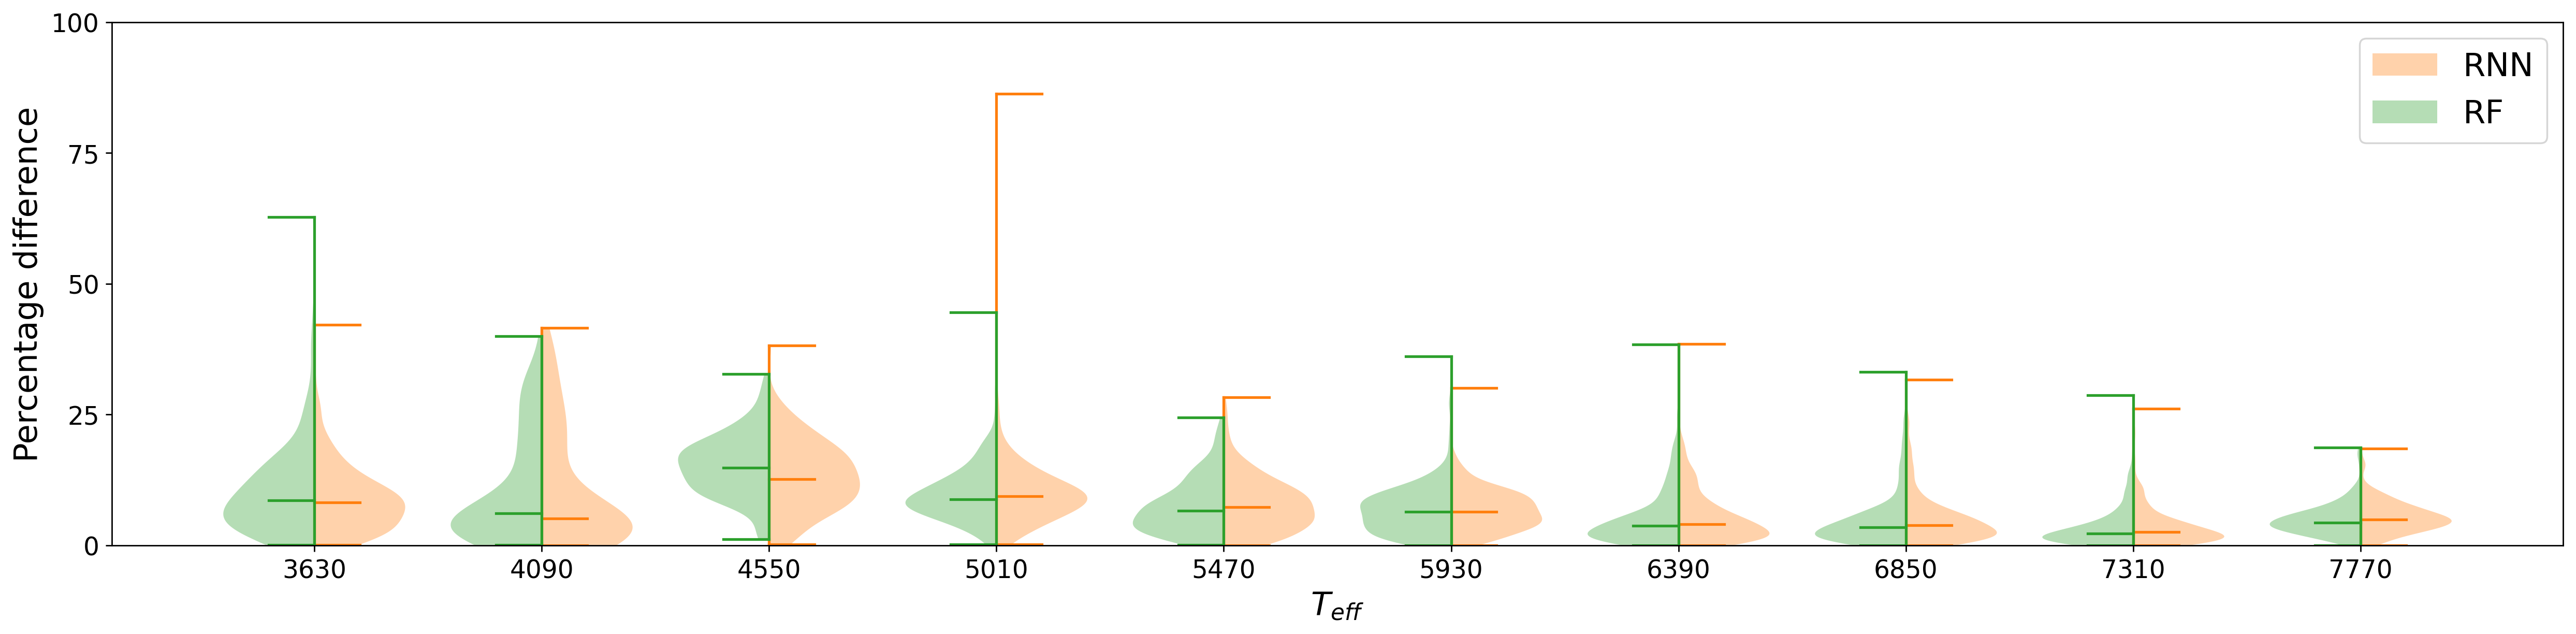

In [240]:
plot_violins(binned_rnn, binned_rf, save=True)

In [241]:
# np.sum([i.shape[0] for i in binned_rnn]), np.sum([i.shape[0] for i in binned_rf])

In [250]:
param = 'Radius'
n_bins =10
# Get files
results_rnn = read_results(param, 'rnn')
results_rf  = read_results(param, 'rf')

# Extract results from rf and rnn
rnn = get_results(results_rnn, from_rf=False)
rf = get_results(results_rf, from_rf=True)

# Define the columns to read, for each param
true = 'True_'+param
mean= 'mean_'+param
median = 'median_'+param
# Select the output with measured values
rf_output = rf[[true, mean, median]][rf[true]>0].copy()
rnn_output = rnn[[true, mean, median]][rnn[true]>0].copy()

# Compute the absolute percent difference
perc_dif = lambda df : 100*np.abs(df[true]-df[median])/df[true]
rf_output['p_diff']=perc_dif(rf_output)
rnn_output['p_diff']=perc_dif(rnn_output)

# Create the bins based on the measured values
max_param = rnn_output[true].max()
min_param = rnn_output[true].min()


# Override the parameter range with a round value
if survey=='PanStarrs':
    if param=='T_eff':
        max_param = 8000
        min_param = 3400
    elif param=='Radius':
        max_param = 200
        min_param = 0    
param_range = max_param - min_param
bins = np.linspace(min_param, max_param, n_bins + 1)  # 21 edges to create 20 bins

# Find the middle point of each bin
mid_bins = [(bins[i] + bins[i+1]) / 2 for i in range(n_bins)]

# Create the string representation of the midpoints
# Justify with 0
centers = [str(round(i, 0)).ljust(7,'0') for i in mid_bins]
centers = [str(int(i)) for i in mid_bins]
# Apply the binning function to the two datasets
binned_rf = bin_data(rf_output, bins, true)
binned_rnn = bin_data(rnn_output, bins, true)


dict_keys(['Radius'])
Radius


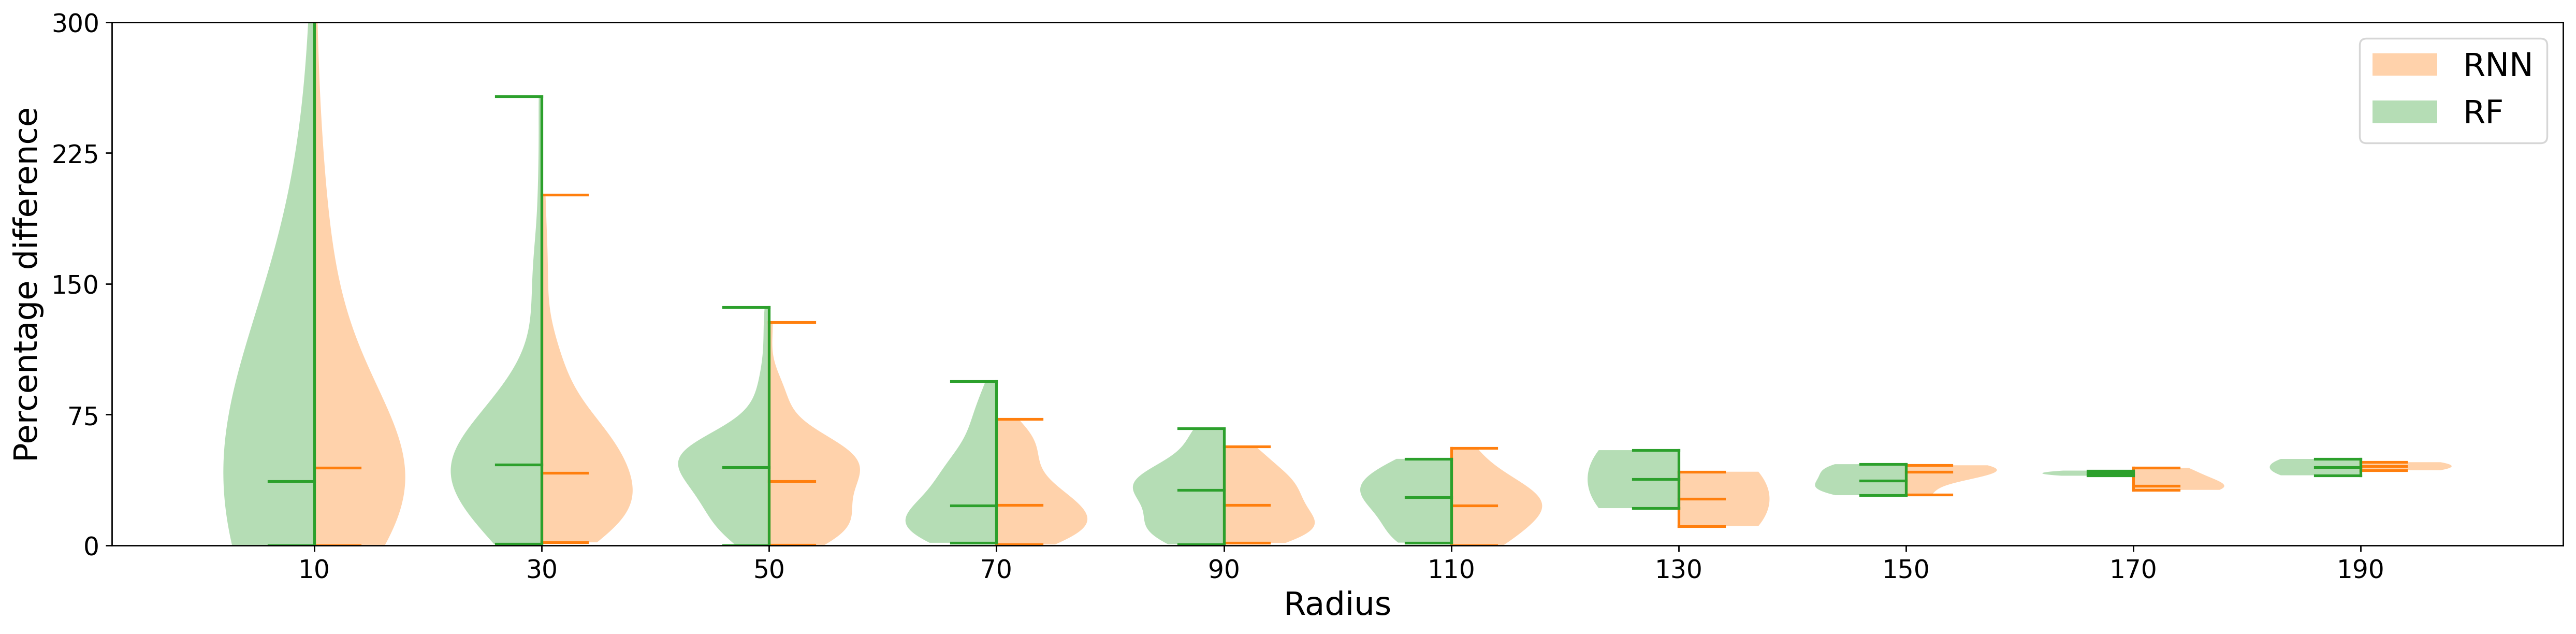

In [251]:
plot_violins(binned_rnn, binned_rf, save=True)